In [71]:
import scipy.io as sio
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.manifold import TSNE
import multiprocessing
import logging  # Setting up the loggings to monitor gensim
from sklearn.preprocessing import MultiLabelBinarizer
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
# Train a one-vs-rest logistic regression classifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split

import concurrent.futures
import os
import sys
import datetime

cores = multiprocessing.cpu_count()  # Count the number of cores in a computer

In [72]:

class Node2Vec():
        def __init__(
                        self, 
                        graph : 'dict[np.ndarray]', 
                        window_size : int, 
                        embedding_size : int, 
                        walks_per_vertex : int, 
                        walk_length : int,
                        p : float,
                        q : float
                ) -> None:
                """
                Initialize the DeepWalk model. This directly from the paper https://arxiv.org/pdf/1403.6652.pdf.

                Parameters
                ----------
                graph : list[list[int]]
                        The adjacency list to be embedded. This is a dict of a np.array. Where adj_list[vertex][0] gives the neighbours indices.
                        adj_list[vertex][1] = weights of edges.
                window_size : int
                        The window size for the skipgram model.
                embedding_size : int
                        The size of the embedding. The final output matrix will be of size |V| x embedding_size.
                walks_per_vertex : int
                        The number of walks to perform per vertex.
                walk_length : int
                        The length of each walk.
                p : float
                        The return parameter.
                q : float
                        The in-out parameter.

                Methods
                -------
                generate_n_walks()
                        Generate n walks from the graph.
                train()
                        Train the model.
                update()
                        Feed model new walks.
                get_embeddings()
                        Return the embeddings.
                """

                # DeepWalk parameters
                self.g = graph
                self.w = window_size
                self.d = embedding_size
                self.gamma = walks_per_vertex
                self.epochs = self.gamma
                self.t = walk_length
                self.n = len(graph)
                self.p = p
                self.q = q
                
                # Cutoffs for sampling
                self.p0 = 1 / self.p / max(1, self.p, self.q)
                self.p1 = 1/  max(1, self.p, self.q)
                self.p2 = 1 / self.q / max(1, self.p, self.q)
        
        def get_random_neighbour(self, vertex : 'int') -> 'int':
                """
                Fetches a random neighbour of a given vertex
                by sampling on the basis of the edge weights
                
                Parameters
                ----------
                vertex : int
                        The vertex whose neighbour we will sample
                        
                Returns
                -------
                int
                        The neighbour that was sampled
                """

                # Sample a vertex with probability proportional 
                # to the weight of the edge joining it.
                return int(np.random.choice(self.g[vertex][0], p=self.g[vertex][1]))
        
        def binary_search(self, arr, target): 
                # Perform binary search
                index = np.searchsorted(arr, target)

                # Check if the value was found at the given index
                return index < len(arr) and arr[index] == target

        def second_order_biased_random_walk(
                        self,
                        adj_list, 
                        walk_len : 'int', 
                        start_node : 'int', 
                        return_parameter :'float', 
                        in_out_parameter : 'float'
                        ) -> np.array:
                """
                Return a walk based on a 2nd order Markov Chain like transition.

                Parameters
                ----------
                adj_mat : list[list[int]]
                        Adjacency matrix of the graph.
                walk_len : int
                        Length of the random walk.
                start_node : int
                        Starting node of the random walk.
                return_parameter : float
                        The value of the "p" parameter
                in_out_parameter : float
                        The value of the "q" parameter
                
                Returns
                -------
                np.array
                        List of nodes in the random walk.  
                
                """
                # Array to store the walk
                walk = [
                        start_node,
                        self.get_random_neighbour(start_node) # The prev_node is never Null
                ]

                # Generate the rest of the walk
                for i in range(2, walk_len):
                    # Variable to check whether we added to walk
                    found = False
                    
                    # Kep running until sampled in the red region
                    while not found:
                        new_node = self.get_random_neighbour(walk[-1])
                        r = np.random.rand()

                        # Check if we will go back to the same node
                        if new_node == walk[-2]:
                            if r < self.p0:
                                found = True
                        
                        # Check if we are going to move by a distance of 1
                        # elif self.g[walk[-2]][new_node]:
                        elif self.binary_search(self.g[walk[-2]][0], new_node):
                            if r < self.p1:
                                found = True
                                    
                        else: # So we are moving by a distance of 2
                            if r < self.p2:
                                found = True
                                
                    walk.append(new_node)
            
                return walk

        def generate_walks_for_iteration(self, args):
                gamma, g, t, p, q, iteration = args
                np.random.seed(iteration)
                
                walks = []

                # print(f"Started with Iteration #{iteration} at {datetime.datetime.now()}", file=sys.stdout)
                
                for vertex in range(self.n):
                        walks.append(self.second_order_biased_random_walk(g, t, vertex, p, q))

                print(f"Done with Iteration #{iteration} at {datetime.datetime.now()}", file=sys.stdout)

                filename = f"./walks/walks_{iteration}.txt"

                with open(filename, 'a') as file:
                        for walk in walks:
                                walk_str = ' '.join(str(node) for node in walk)
                                file.write(walk_str + '\n')

                walks = []

        def generate_n_walks_parallel(self, num_iters: int, num_cores):
                args_list = [(self.gamma, self.g, self.t, self.p, self.q, iteration) for iteration in range(self.gamma)]

                with concurrent.futures.ProcessPoolExecutor(max_workers=num_cores) as executor:
                        executor.map(self.generate_walks_for_iteration, args_list)

                # print(f"Done with {self.n * num_iters} nodes at {datetime.datetime.now()}", file=sys.stdout)

        def train(self, epochs : int, lr : float) -> None:
                """
                Train the model.

                Parameters
                ----------
                epochs : int
                        Number of epochs to train the model for.
                lr : float
                        Learning rate for the optimizer.                
                """         

                print("Start generating random walks", file=sys.stdout) 
                start = time.perf_counter()
                # Generate many walks
                walks = self.generate_n_walks_parallel(self.gamma, cores)
                end = time.perf_counter()
                print(f"Done generating random walks in {round(end - start, 2)} seconds", file=sys.stdout)

                print("Creating word2vec model", file=sys.stdout)

                walks = None

                # Initialize the model
                self.model = Word2Vec(
                        walks,
                        negative= 10,
                        sg=1,
                        alpha=0.05,
                        epochs=epochs, 
                        vector_size=self.d,        # embedding dimension
                        window=self.w,             # context window size
                        min_count=0,
                        workers=cores-2
                )

                for iteration in range(self.gamma):
                        walks_file = f"./walks/walks_{iteration}.txt"
                        if os.path.exists(walks_file):
                                walks = LineSentence(walks_file)

                                # Train the model incrementally
                                self.model.build_vocab(walks, update=(iteration != 0))
                                self.model.train(walks, total_examples=self.model.corpus_count, epochs=epochs)
                        
                        if (iteration % 10) == 0:
                                print(f"Done training the model on the {iteration}th iteration", file=sys.stdout)

                print("Done creating word2vec model", file=sys.stdout)


In [73]:
def les_miserables_graph():
    # Create the Les Misérables graph from the built-in dataset in NetworkX
    G = nx.les_miserables_graph()
    return G

def convert_nodes_to_integers(graph):
    # Create a mapping between original string labels and integer labels
    node_mapping = {node: i for i, node in enumerate(graph.nodes)}

    # Convert nodes to integers in the graph
    graph_int = nx.relabel_nodes(graph, node_mapping)

    return graph_int, node_mapping

def sparse_matrix_to_adjacency_list(graph):
    adjacency_list = {}
    for node in graph.nodes:
        neighbors = np.array(list(graph.neighbors(node)), dtype=object)  # Use object type for strings
        weights = np.array([float(graph[node][neighbor]['weight']) for neighbor in neighbors], dtype=float)

        # Normalize weights
        weights /= np.sum(weights)

        # Sort neighbors and weights by node number
        sort_order = np.argsort(neighbors)
        neighbors = np.array(neighbors[sort_order], dtype=object)  # Use object type for strings
        weights = weights[sort_order]

        adjacency_list[node] = np.column_stack((neighbors, weights)).T

    return adjacency_list


In [74]:
# Create the Les Misérables graph
les_miserables_graph1 = les_miserables_graph()

# Convert nodes to integers and get the mapping
les_miserables_graph_int, node_mapping = convert_nodes_to_integers(les_miserables_graph1)

# Convert the graph to an adjacency list
adjacency_list = sparse_matrix_to_adjacency_list(les_miserables_graph_int)

# # Print the adjacency list and node mapping
# print("Adjacency List:")
# print(adjacency_list)

# print("\nNode Mapping:")
# print(node_mapping)

In [75]:
def load_embeddings(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Extract number of nodes and dimensions
    num_nodes, dimensions = map(int, lines[0].split())

    # Initialize an empty array for embeddings
    embeddings = np.zeros((num_nodes, dimensions))

    # Parse lines and fill the embeddings array
    for i, line in enumerate(lines[1:]):
        parts = line.split()
        node_id = int(parts[0])
        vector = np.array(list(map(float, parts[1:])))
        embeddings[node_id] = vector

    return embeddings

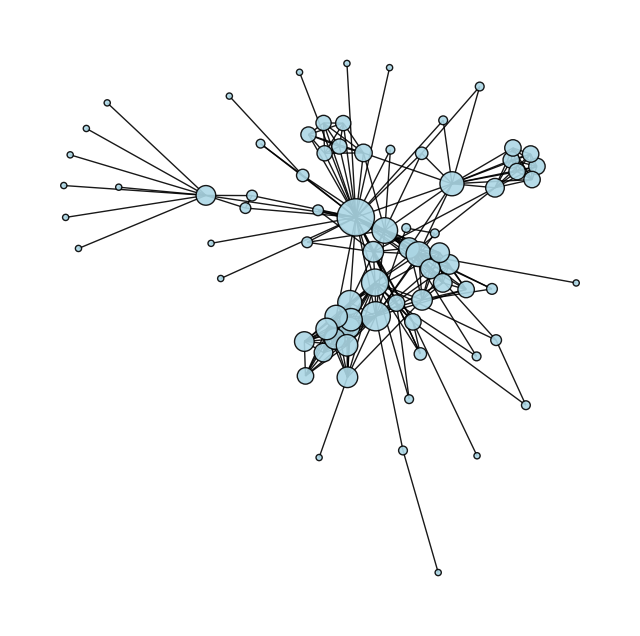

In [76]:
def plot_graph ( G , node_colours):
        plt.figure(figsize=(8,8))
        # scale node size by degree
        node_sizes = [v * 20 for v in dict(G.degree()).values()]
        nx.draw_networkx(G, with_labels=False, node_color= node_colours, node_size= node_sizes,edgecolors="black", alpha=0.9)
        plt.axis("off")
        plt.show()

G = nx.les_miserables_graph()
plot_graph(G, "lightblue")

# Homophily 

In [77]:
dw = Node2Vec(adjacency_list, 3, 16, 12, 3, 1, 0.5)
print("Node2Vec object created", file=sys.stdout)

master_start = time.time()

print("Training started...", file=sys.stdout)
dw.train(20, 0.05)
print("Training completed", file=sys.stdout)

print("Saving embeddings...", file=sys.stdout)
dw.model.wv.save_word2vec_format('les_miserables.txt')
print("Embeddings saved", file=sys.stdout)

master_end = time.time()

print("All done in ", master_end - master_start, " seconds")

Node2Vec object created
Training started...
Start generating random walks
Done generating random walks in 0.1 seconds
Creating word2vec model
Done training the model on the 0th iteration
Done training the model on the 10th iteration
Done creating word2vec model
Training completed
Saving embeddings...
Embeddings saved
All done in  0.10428166389465332  seconds


In [78]:
from sklearn.cluster import KMeans

# Example usage
embeddings_path = 'les_miserables.txt'
embeddings = load_embeddings(embeddings_path)
# print(embeddings)

kmeans = KMeans(n_clusters=5, random_state=0,n_init=10).fit(embeddings)
labels = kmeans.labels_

plot_graph(G, labels)

ValueError: Found array with 0 sample(s) (shape=(0, 16)) while a minimum of 1 is required by KMeans.

# Structural Equivalence

In [ ]:
dw = Node2Vec(adjacency_list, 3, 16, 12, 3, 1, 2)
print("Node2Vec object created", file=sys.stdout)

master_start = time.time()

print("Training started...", file=sys.stdout)
dw.train(20, 0.05)
print("Training completed", file=sys.stdout)

print("Saving embeddings...", file=sys.stdout)
dw.model.wv.save_word2vec_format('les_miserables.txt')
print("Embeddings saved", file=sys.stdout)

master_end = time.time()

print("All done in ", master_end - master_start, " seconds")

Node2Vec object created
Training started...
Start generating random walks
Done generating random walks in 0.13 seconds
Creating word2vec model
Done training the model on the 0th iteration
Done training the model on the 10th iteration
Done creating word2vec model
Training completed
Saving embeddings...
Embeddings saved
All done in  1.7148187160491943  seconds


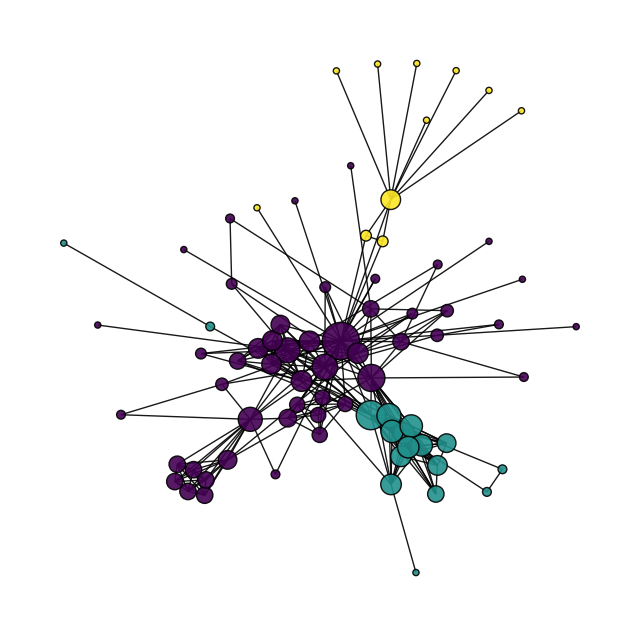

In [ ]:
from sklearn.cluster import KMeans

# Example usage
embeddings_path = 'les_miserables.txt'
embeddings = load_embeddings(embeddings_path)
# print(embeddings)

kmeans = KMeans(n_clusters=3, random_state=0,n_init=10).fit(embeddings)
labels = kmeans.labels_

plot_graph(G, labels)